# Выпускной проект. Анализ поведения пользователей в мобильном приложении

## Описание проекта

Дерзкая и амбициозная команда сервиса «Ненужные вещи» жаждет увидеть в своём составе крутого аналитика, который возьмёт огромное количество наших данных и сотворит из них чудо. Конкретнее про чудо: наши пользователи совершают много действий в приложении, и мы уверены, что в этих данных есть инсайты, которые позволят нам стать лучшим приложением для продажи ненужных вещей. В рамках работы необходимо проанализировать поведение пользователей в мобильном приложениии "Ненужные вещи" и сегментировать их на разные группы для того, чтобы наладить более точный механизм взаимодействия с пользователями и повысить вовлеченность групп пользователей с низкими показателями.

## Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в *mobile_sources.csv*:

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в mobile_dataset.csv: **

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

## План исследования

1. Загрузка и предобработка данных

  - Предобработка данных

    - Исследование и обработка дубликатов
    - Исследование пропусков и их обработка
    - Переименование стобцов
    - Проверка типов данных, приведение к нужным типам данных
    - Обработка времени и даты, выделение необходимых временных промежутков
---
2. Анализ связи целевого события — просмотра контактов — и других действий пользователей.
  - Анализ сессий. Для кажого пользователя и действия 'contact_show' (show_contact) найти предыдущее и получть конверсию каждого действия в целевое
  - Рассчет среднего времени от первого действия до целевого события
  - Разделение пользователей на совершающих целевое действие и несовершающих. Анализ этих групп (время между поиском и открытием объявлений)
  - Составление сценариев использования приложений

---
3. Оценка частоты действий пользователей, которые просматривают контакты.
  - Срез всех пользователей, которые просматривают контакты и подсчет количества событий
  - Исследовательский анализ данных
    - Проверка равномерности распределений событий по дням
    - Retention Rate
    - DAU
    - Время, проведенное в приложении
    - Выводы
  

---
5. Общие выводы и рекомендации
---
6. Создание дашборда
---
7. Создание презентации

In [1]:
# импорт библиотек, необходимых для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
import warnings
warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

## Предобработка данных

In [2]:
  mobile_sources = pd.read_csv('mobile_sources.csv')
  mobile_dataset = pd.read_csv('mobile_dataset.csv')

In [3]:
mobile_sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [6]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В обоих датасетах отсутствуют пропуски, для дальнейшего удобства переименуем столбцы датасетов. С типами данных также все хорошо, за исключением 'event_time', приведем его к типу datetime

In [7]:
mobile_sources.rename(columns={'userId': 'user_id'}, inplace=True)

In [8]:
mobile_dataset.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'}, inplace=True)

In [9]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

Теперь с данными удобно работать.

События 'show_contacts' и 'contacts_show' одно и тоже событие событие записанное в двух вариантах. Заменим 'show_contacts' на 'contacts_show'.

In [10]:
mobile_dataset.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [11]:
mobile_dataset['event_name'].replace('show_contacts', 'contacts_show', inplace=True)

После замены можно проверить дубликаты.

In [12]:
mobile_dataset.duplicated().sum()

0

In [13]:
mobile_sources.duplicated().sum()

0

Ни в одном из датасетов явных дубликатов нет

Дейсвтия начинающиеся с "search" можно объединить, тк расшифровки о каждом действии нет и при дальнейшем анализе будем учитывать только сам поиск.

In [14]:
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace('search_+\d', 'search', regex=True)

Посмотрим за какой период у нас есть данные

In [15]:
print(f'Период анализа: {mobile_dataset["event_time"].min().date()} - {mobile_dataset["event_time"].max().date()}')
print(f'Количество дней и часов: {mobile_dataset["event_time"].max()-mobile_dataset["event_time"].min()}')

Период анализа: 2019-10-07 - 2019-11-03
Количество дней и часов: 27 days 23:58:12.101130


Добавим столбец только с датой

In [16]:
mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date

Посмотрим есть ли выбросы по количеству событий

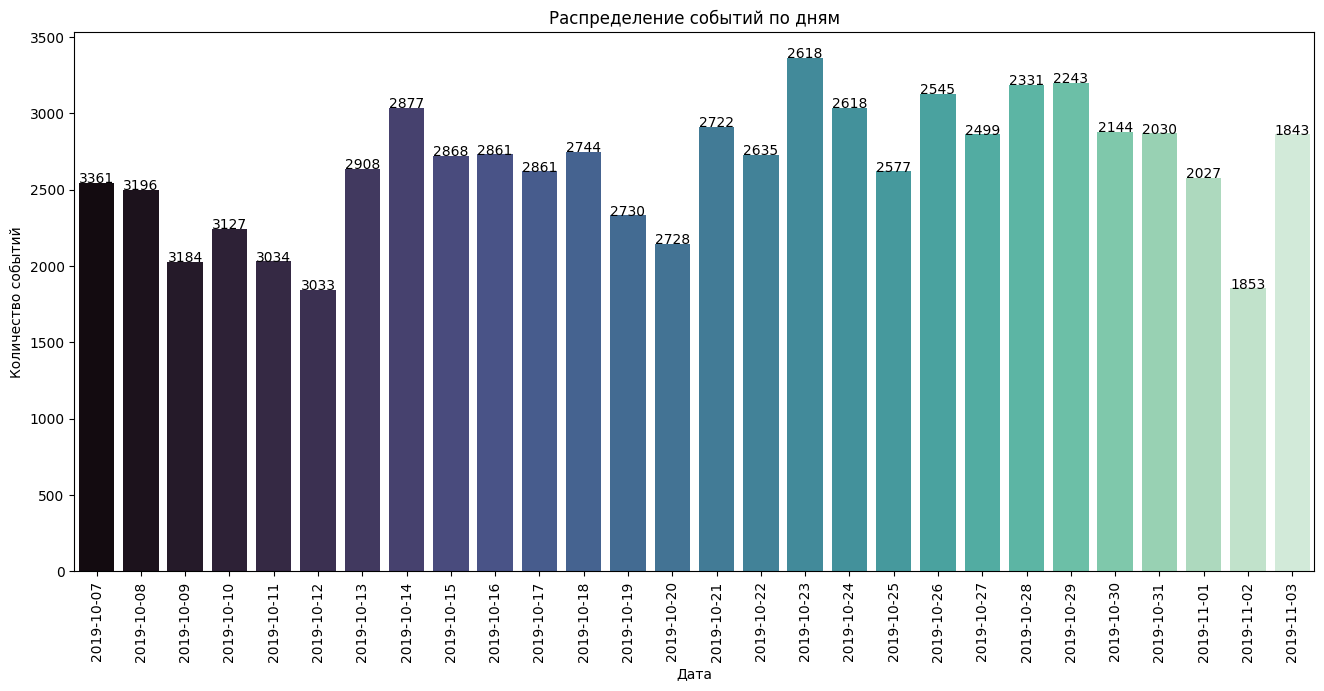

In [17]:
plt.figure(figsize = (16,7))
ax = sns.countplot(x='event_date', data=mobile_dataset, palette='mako')
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        mobile_dataset['event_date'].value_counts()[i],ha="center")
    i += 1
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням');

Аномально больших или малых значений нет, самый насыщенный на события день - 23 октября 2019 года - среда

Проверим количество уникальных пользователей

In [18]:
mobile_dataset.user_id.nunique()

4293

In [19]:
mobile_sources.shape

(4293, 2)

Количество уникальных пользователей совпадает с размером датасета mobile_sources

Проверим аномалии в количестве действий на пользователя

In [20]:
events_count = mobile_dataset.groupby('user_id', as_index=False)[['event_name']].count()
events_count.columns = ['user_id','event_count']
events_count.describe()

,event_count
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


Минимальное количество событий на пользователя - 1, максимальное - 478. Проверим период за который он совершил эти действия.

In [21]:
active_user = events_count.sort_values(by='event_count', ascending=False).reset_index()['user_id'][0]
active_user

'cb36854f-570a-41f4-baa8-36680b396370'

In [22]:
mobile_dataset.query('user_id == @active_user')['event_time'].describe()

count                            478
unique                           478
top       2019-10-07 11:39:42.961713
freq                               1
first     2019-10-07 11:39:42.961713
last      2019-11-01 14:34:02.472249
Name: event_time, dtype: object

Период активности этого пользователя - 25 дней. За день он совершал ~19 событий, не так много, чтобы считать это аномалией.

Посмотрим сколько пользователей совершивших 1 событие

In [23]:
events_count[events_count['event_count'] == 1].shape[0]

65

Более внимательно глянем на описательную статистику в получившимся датафрейме

In [24]:
events_count.describe(percentiles=[0.05, 0.25, 0.5, 0.90, 0.95, 0.99])

,event_count
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
5%,3.000000
25%,5.000000
50%,9.000000
90%,36.000000
95%,59.000000
99%,132.000000


In [25]:
events_count[events_count['event_count'] == 1].shape[0] / mobile_dataset.shape[0]

0.0008760462013288948

Среднее количество действий на пользователя 17, медианное 9. Пользователи, совершившие одно действие составляют меньше 0.1%, эти данные можно отбросить, признав выбросами

In [26]:
drop_list = list(events_count[events_count['event_count'] == 1]['user_id'].unique())
mobile_dataset = mobile_dataset.query('user_id not in @drop_list')

В результате предобработки данных мы переименовали стоблцы, привели к нужным типам данных, ознакомились с содержимым датафреймов, убрали аномалии. Можно приступать к более глубобкому анализу

## Retention Rate

Посмотрим период выборки. Возьмём дату, когда пользователь впервые проявил активность в мобильном приложении.

In [27]:
first_date = mobile_dataset.groupby(['user_id'])['event_date'].min()
first_date.name = 'start_dt'
retention = mobile_dataset.join(first_date,on='user_id')

In [28]:
retention.sample(10)

,event_time,event_name,user_id,event_date,start_dt
42423,2019-10-23 19:53:41.162343,tips_show,c7c295ca-1136-4b80-b3d2-df46c51c6be3,2019-10-23,2019-10-23
6215,2019-10-09 15:52:52.586463,tips_show,cb36854f-570a-41f4-baa8-36680b396370,2019-10-09,2019-10-07
59438,2019-10-29 15:06:35.167322,tips_show,abdcbe3c-221b-4f59-afd9-bf9ca78f7e4c,2019-10-29,2019-10-11
35099,2019-10-21 13:38:46.404504,map,303f9d8e-9879-4322-ba19-74de623ccbd6,2019-10-21,2019-10-21
27802,2019-10-18 12:08:48.827422,tips_show,086ac129-e8e1-4875-84ea-a66d84b267d1,2019-10-18,2019-10-18
63731,2019-10-30 21:23:14.199165,tips_show,167da392-cecb-44f9-85c8-c26e013c5de1,2019-10-30,2019-10-12
56625,2019-10-28 16:16:59.316719,advert_open,ca794dbd-ddd2-4f88-9c4c-eadc1f67a68e,2019-10-28,2019-10-21
15599,2019-10-13 22:45:21.476190,tips_show,cfd9b735-0bc2-448d-8d54-0019db8748a3,2019-10-13,2019-10-11
25705,2019-10-17 15:06:22.431907,tips_show,5da6f553-9943-4a2c-940f-9ee7f292e438,2019-10-17,2019-10-14
11431,2019-10-12 06:42:35.895931,advert_open,cd06ad18-1629-42bf-b9c1-6edc863bf709,2019-10-12,2019-10-10


In [29]:
retention['start_dt'] = retention['start_dt'].astype('datetime64[ns]')
retention['event_date'] = retention['event_date'].astype('datetime64[ns]')
retention['activ_week'] = pd.to_datetime(retention['event_date'],
                                                unit='d') - pd.to_timedelta(retention['event_date'].dt.dayofweek, unit='d')
retention['start_week'] = pd.to_datetime(retention['start_dt'],
                                                      unit='d') - pd.to_timedelta(retention['start_dt'].dt.dayofweek, unit='d')

Рассчитаем лайфтайм

In [30]:
retention['cohort_lifetime'] = retention['activ_week'] - retention['start_week']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'W')
retention['cohort_lifetime'] = retention['cohort_lifetime'].astype(int)

Сгруппируем данные по когорте и lifetime.

In [31]:
cohorts = retention.groupby(['start_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

Найдём количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [32]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['start_week','user_id']]

In [33]:
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='start_week')

Посчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте

In [34]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
cohorts['start_week'] = cohorts['start_week'].dt.date
retention_pivot = cohorts.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

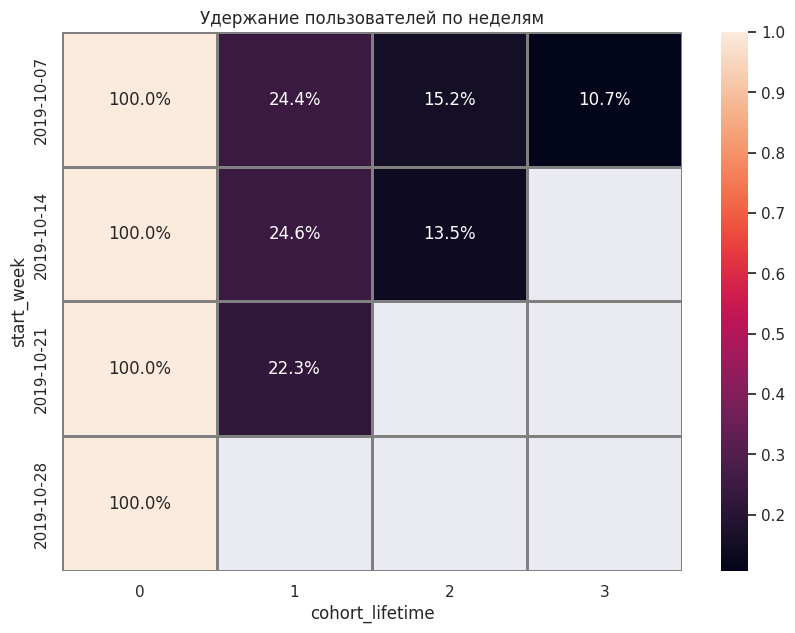

In [35]:
sns.set(style='dark')
plt.figure(figsize=(10, 7))
plt.title('Удержание пользователей по неделям')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Retention Rate в первую неделю убывает по когортам с течением времени.
Для когорты 7 октября по 13 октября Retention Rate в первую неделю составляет 24.4%, то для пользователей, пришедших с 21 по 27 октября — уже 22.3%. Так, за 2 недели коэффициент удержания упал на 2.1%.

## DAU

In [36]:
dau_all = mobile_dataset.groupby('event_date')['user_id'].nunique()
dau_all.describe()

count     28.000000
mean     276.857143
std       46.339899
min      177.000000
25%      237.500000
50%      289.500000
75%      309.250000
max      347.000000
Name: user_id, dtype: float64

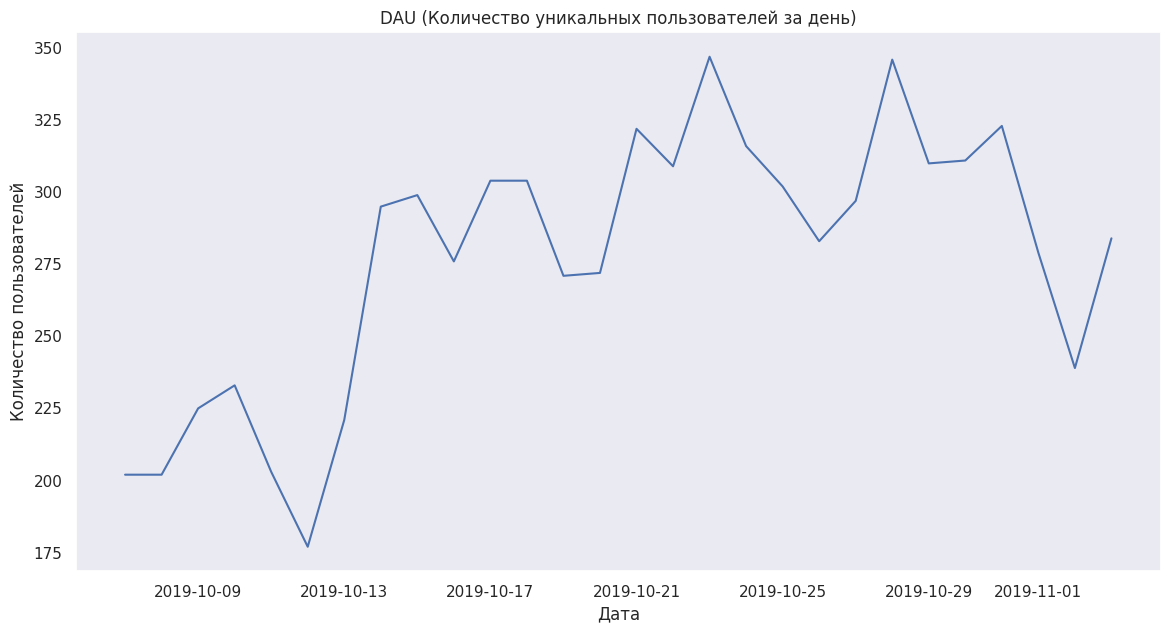

In [37]:
plt.figure(figsize = (14,7))
plt.plot(dau_all)
plt.title('DAU (Количество уникальных пользователей за день)')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

В среднем в день было 276 пользователей, максимум и минимум пользователей в день 346 и 177, соответветственно

## Сбор данных о сессиях

Отсортируем датафрейм по id пользователя и времени события, чтобы в дальнейшем получить данные о сессиях

In [38]:
df = mobile_dataset.sort_values(['user_id', 'event_time']).reset_index(drop=True)

Добавим к каждой сессии информацию о ее начале, конце, длительности и лайфтайму пользователя на момент этой сессии - время от первого захода в приложение до этой сессии в днях. Подсчитаем также, сколько действий за кажду сессию пользователь совершил.

Для подсчета количества сессий отсортируем данные по пользователям и времени и добавим столбцы delta  - время до предыдущего события и session - номер сессии пользователя, в которую попадает событие.

Будем выделять сессии относительно тайм-аута. Тайм-аут возьмем равным 3 часам, исходя из рассчета тайм-аута визита в Яндекс.Метрике  (https://yandex.ru/support/metrica/general/counter-general.html). Считать будем по формуле среднего значения

\begin{align}
Time\_out\_mean = \frac{time\_out\_min} {time\_out\_max}
\end{align}

Минимальное значение 30 минут, максимальное 360. Среднее получается 3.25, округлим до 3

In [39]:
#convert to datetimes
df['event_time'] = pd.to_datetime(df['event_time'])
#identify difference 5Min for each group with cumulative sum
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta(hours=3)).cumsum()
#create counter of groups
df['session'] = df.groupby(['user_id', g], sort=False, as_index=False).ngroup() + 1
display(df)

,event_time,event_name,user_id,event_date,session
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
...,...,...,...,...,...
74127,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,8548
74128,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,8548
74129,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,8548
74130,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,8548


In [40]:
df.event_time.max() - df.event_time.min()

Timedelta('27 days 23:58:12.101130')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74132 entries, 0 to 74131
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74132 non-null  datetime64[ns]
 1   event_name  74132 non-null  object        
 2   user_id     74132 non-null  object        
 3   event_date  74132 non-null  object        
 4   session     74132 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.8+ MB


In [42]:
pd.set_option("display.float_format", "{:.2f}".format)
# создаем датафрейм с сессиями
sessions = df.groupby(['user_id', 'session']).agg({'event_time':['first', 'last'],
                                                   'event_name':'count'}).reset_index()

sessions.columns = ['user_id', 'session', 'session_start', 'session_end', 'events_count']

# создаем датафрейм для самого первого события у каждого пользователя
user_start = df.groupby('user_id').agg({'event_time':'first'}).reset_index()
user_start.rename(columns={'event_time':'first_visit'}, inplace=True)

# присоединяем к данным о сессиях
sessions = sessions.merge(user_start, on='user_id', how='left')

# вычисляем лайфтайм для каждой сессии в днях
sessions['lifetime'] = (sessions['session_start'] - sessions['first_visit']).dt.days

# сохраняем отдельно день визита в приложение
sessions['dt'] = sessions['first_visit'].dt.date
# длительность сессии - как промежуток между первым и последним событием в сессии
sessions['length'] = sessions.session_end - sessions.session_start

# переведем в секунды
sessions['length'] = sessions['length'].dt.total_seconds()
sessions

,user_id,session,session_start,session_end,events_count,first_visit,lifetime,dt,length
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9,2019-10-07 13:39:45.989359,0,2019-10-07,595.73
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4,2019-10-07 13:39:45.989359,2,2019-10-07,507.39
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14,2019-10-07 13:39:45.989359,14,2019-10-07,899.27
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,8,2019-10-07 13:39:45.989359,14,2019-10-07,758.17
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,9,2019-10-19 21:34:33.849769,0,2019-10-19,1520.79
...,...,...,...,...,...,...,...,...,...
8543,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,8544,2019-10-30 11:31:45.886946,2019-10-30 11:31:45.886946,1,2019-10-12 00:57:21.241896,18,2019-10-12,0.00
8544,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,8545,2019-11-01 00:24:31.162871,2019-11-01 00:24:53.473219,2,2019-10-12 00:57:21.241896,19,2019-10-12,22.31
8545,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,8546,2019-11-02 01:16:48.947231,2019-11-02 01:16:48.947231,1,2019-10-12 00:57:21.241896,21,2019-10-12,0.00
8546,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,8547,2019-11-02 18:01:27.094834,2019-11-02 19:30:50.471310,6,2019-10-12 00:57:21.241896,21,2019-10-12,5363.38


## Подсчитаем время поиска и открытия advert в сессии

In [43]:
target = df.query('event_name == "contacts_show"')['user_id']

In [44]:
target_session = df.query('user_id in @target')
not_target_session = df.query('user_id not in @target')

In [45]:
target_session = pd.merge(target_session, target_session.query('event_name == "search"').groupby('session', as_index=False).agg({'event_time': 'first'}).rename({'event_time': 'search'}, axis='columns'), how = 'left', on = ['session'])
target_session = pd.merge(target_session, target_session.query('event_name == "advert_open"').groupby('session', as_index=False).agg({'event_time': 'first'}).rename({'event_time': 'advert_open'}, axis='columns'), how = 'left', on = ['session'])
not_target_session = pd.merge(not_target_session, not_target_session.query('event_name == "search"').groupby('session', as_index=False).agg({'event_time': 'first'}).rename({'event_time': 'search'}, axis='columns'), how = 'left', on = ['session'])
not_target_session = pd.merge(not_target_session, not_target_session.query('event_name == "advert_open"').groupby('session', as_index=False).agg({'event_time': 'first'}).rename({'event_time': 'advert_open'}, axis='columns'), how = 'left', on = ['session'])


In [46]:
target_session['gap'] = target_session['advert_open'] - target_session['search']
not_target_session['gap'] = not_target_session['advert_open'] - not_target_session['search']

In [47]:
target_session['gap'].agg({'gap': lambda x: x.sum() / x.count()})


gap   -1 days +23:49:59.778763736
Name: gap, dtype: timedelta64[ns]

In [48]:
not_target_session['gap'].agg({'gap': lambda x: x.sum() / x.count()})

gap   0 days 00:00:43.804704698
Name: gap, dtype: timedelta64[ns]

Пользователи, несовершавшие ЦС имеют, среднее время между поиском и открытием объявления в 43 секунды. А пользователи, совершавшие ЦС, ведут себя странно. Получется, что сначала они открывают объявление, а потом ищут.

In [49]:
target_session['gap'].dt.total_seconds()

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
27186   NaN
27187   NaN
27188   NaN
27189   NaN
27190   NaN
Name: gap, Length: 27191, dtype: float64

In [50]:
target_session['gap'].dt.total_seconds()[target_session['gap'].dt.total_seconds() > 0]

36      3116.71
37      3116.71
38      3116.71
39      3116.71
40      3116.71
          ...  
26394     45.66
26395     45.66
26396     45.66
26397     45.66
26398     45.66
Name: gap, Length: 2057, dtype: float64

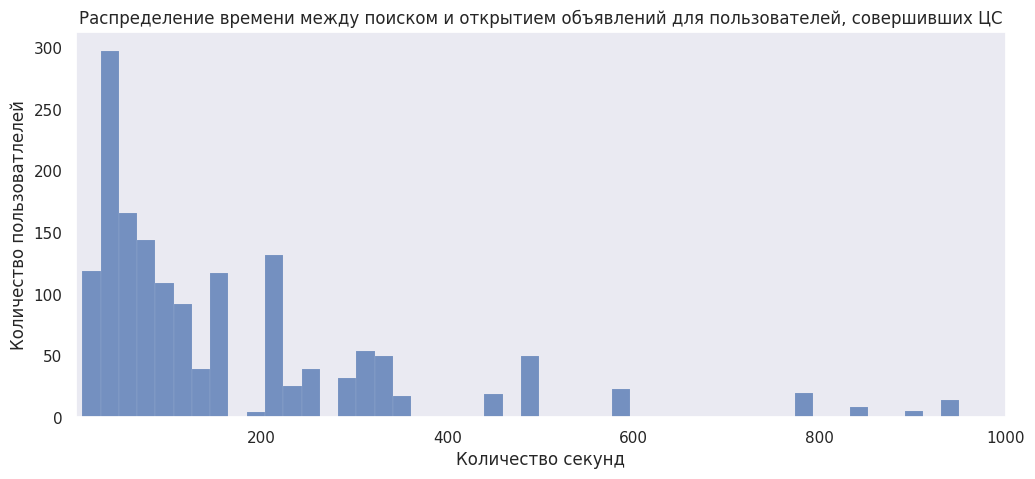

In [51]:
plt.figure(figsize=(12,5))
ax = sns.histplot(target_session['gap'].dt.total_seconds()[target_session['gap'].dt.total_seconds() > 0], bins=1000)
plt.title('Распределение времени между поиском и открытием объявлений для пользователей, совершивших ЦС')
plt.xlabel('Количество секунд')
plt.ylabel('Количество пользоватлелей')
plt.xlim(1, 1000);

In [52]:
target_session['gap'].dt.total_seconds()[target_session['gap'].dt.total_seconds() > 0].describe()

count    2057.00
mean     1025.20
std      2238.30
min         8.00
25%        56.59
50%       159.42
75%       786.57
max     19636.76
Name: gap, dtype: float64

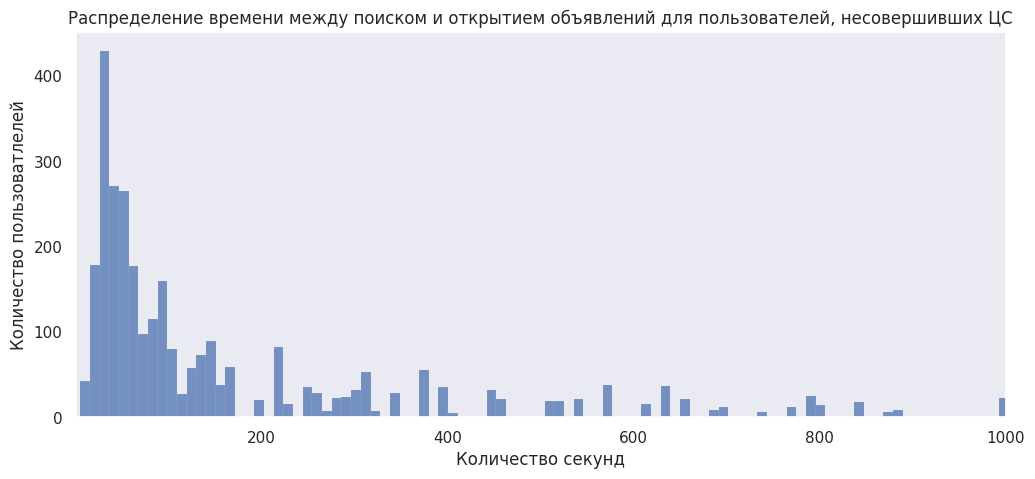

In [53]:
plt.figure(figsize=(12,5))
ax = sns.histplot(not_target_session['gap'].dt.total_seconds()[not_target_session['gap'].dt.total_seconds() > 0], bins=1000)
plt.title('Распределение времени между поиском и открытием объявлений для пользователей, несовершивших ЦС')
plt.xlabel('Количество секунд')
plt.ylabel('Количество пользоватлелей')
plt.xlim(1, 1000);

In [54]:
not_target_session['gap'].dt.total_seconds()[not_target_session['gap'].dt.total_seconds() > 0]

57      2046.70
58      2046.70
59      2046.70
60      2046.70
61      2046.70
          ...  
46846   9047.84
46847   9047.84
46848   9047.84
46849   9047.84
46850   9047.84
Name: gap, Length: 3852, dtype: float64

Для большинства пользователей, совершивших ЦС, время между поиском и открытием объявления проходит ~37 секунд, медианное время - 160 секунд, но присутствует много аномально больших значений.
Для большинства пользователей, несовершивших ЦС, время между поиском и открытием объявления проходит ~30 секунд, медианное время - 47 секунд.


### Профили пользователей

Составим для каждого пользователя профиль - подсчитаем, сколько сессий в приложении совершил пользователь, сколько они длились, сколько всего времени было проведено в приложении, сколько действий в среднем за сессию пользователь совершал, а также информацию, совершил ли пользователь целевое действие - просмотр контактов продавца  и из какого источника пользователь установил приложение.

In [55]:
# составим профили пользователей
users_profiles = sessions.groupby('user_id').agg({'session' : 'max',
                                                  'length':'sum',
                                                  'events_count':'mean'}).reset_index()
# добавим информацию об источнике установки приложения
users_profiles = users_profiles.merge(mobile_sources, on='user_id', how='left')


# для каждого из событий составим столбец с признаком
for event in list(df['event_name'].unique()):
    event_users = list(df[df['event_name'] == event]['user_id'].unique())
    users_profiles[event] = False
    for user in event_users:
        users_profiles.loc[users_profiles['user_id'] == user, event] = True

display(users_profiles.head())
display(users_profiles.describe(percentiles=[0.05, 1/4, 1/2, 0.90, 0.95, 0.99]))

,user_id,session,length,events_count,source,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2760.56,8.75,other,True,True,False,False,False,False,False,False,False
1,00157779-810c-4498-9e05-a1e9e3cedf93,10,11774.21,11.83,yandex,False,False,True,True,True,True,True,True,False
2,00463033-5717-4bf1-91b4-09183923b9df,11,1482.48,10.00,yandex,False,False,False,True,False,False,False,False,False
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,17,6644.36,5.33,google,True,True,True,False,False,False,False,True,False
4,00551e79-152e-4441-9cf7-565d7eb04090,20,559.66,2.67,yandex,False,False,True,True,False,True,True,False,False


,session,length,events_count
count,4228.00,4228.00,4228.00
mean,4288.76,3831.23,9.57
std,2457.73,10734.76,10.02
min,4.00,0.00,1.00
5%,448.50,82.52,2.00
25%,2159.75,430.55,4.00
50%,4295.50,1167.41,6.31
90%,7757.10,9251.18,19.00
95%,8100.65,14709.37,27.00
99%,8434.73,41491.47,50.00


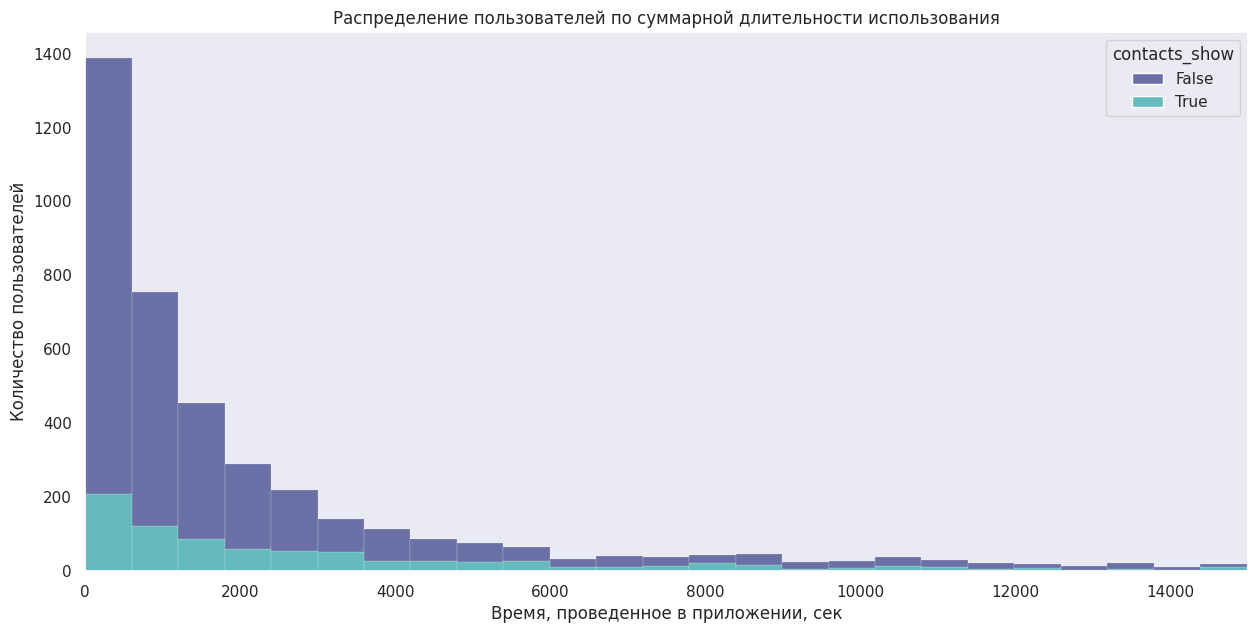

In [56]:
plt.figure(figsize = (15,7))
sns.histplot(x='length', data=users_profiles, hue= 'contacts_show', multiple='stack', bins=590,  palette='mako')
plt.xlabel('Время, проведенное в приложении, сек')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по суммарной длительности использования')
plt.xlim(0, 15000)
plt.show()

В среднем в приложении проводят 3831 секунд, а медианное время ~1180 секунд

Чаще всего у пользователей происходит одна сессия. Посмотрим частоту действий




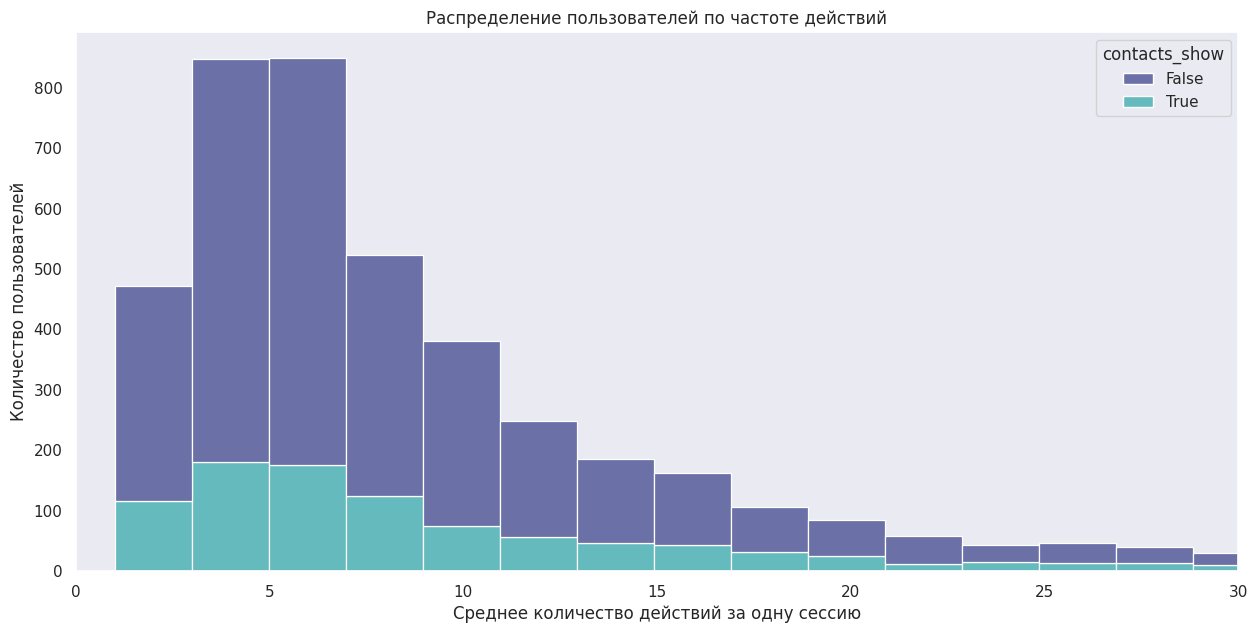

In [57]:
plt.figure(figsize = (15,7))
sns.histplot(x='events_count', data=users_profiles, hue= 'contacts_show', multiple='stack', bins=85, palette='mako')
plt.xlabel('Среднее количество действий за одну сессию')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по частоте действий')
plt.xlim(0, 30)
plt.show()

медианное количество действий у пользователей - 5. Посмотрим распределелние пользователей по источникам привлечения

In [58]:
sorted_source=users_profiles.\
groupby(['contacts_show', 'source'], as_index=False).\
agg({'user_id': 'count'}).\
rename({'user_id':'count'},axis='columns').\
sort_values(by='count', ascending=False)

In [59]:
sorted_source

,contacts_show,source,count
2,False,yandex,1429
1,False,other,981
0,False,google,843
5,True,yandex,476
3,True,google,274
4,True,other,225


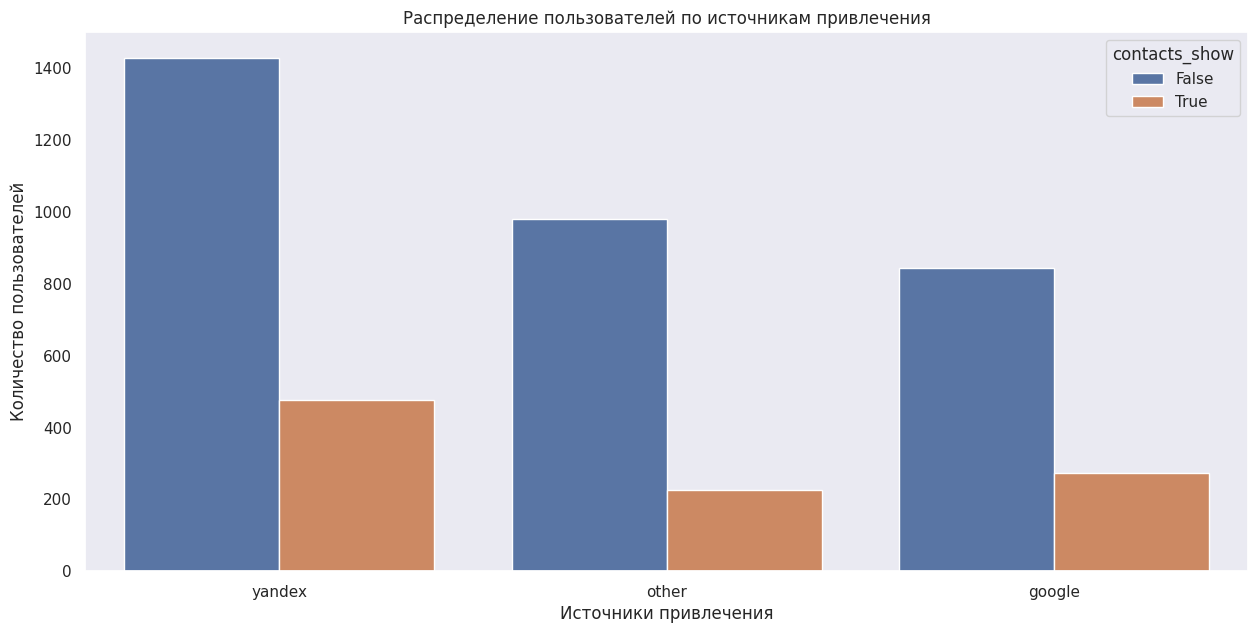

In [60]:
plt.figure(figsize = (15,7))
sns.barplot(data=sorted_source, y='count', x='source', hue='contacts_show',ci=None)
plt.xlabel('Источники привлечения')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по источникам привлечения')
plt.show()

Самый популярный источник привлечения - Яндекс. Построим матрицу корреляций

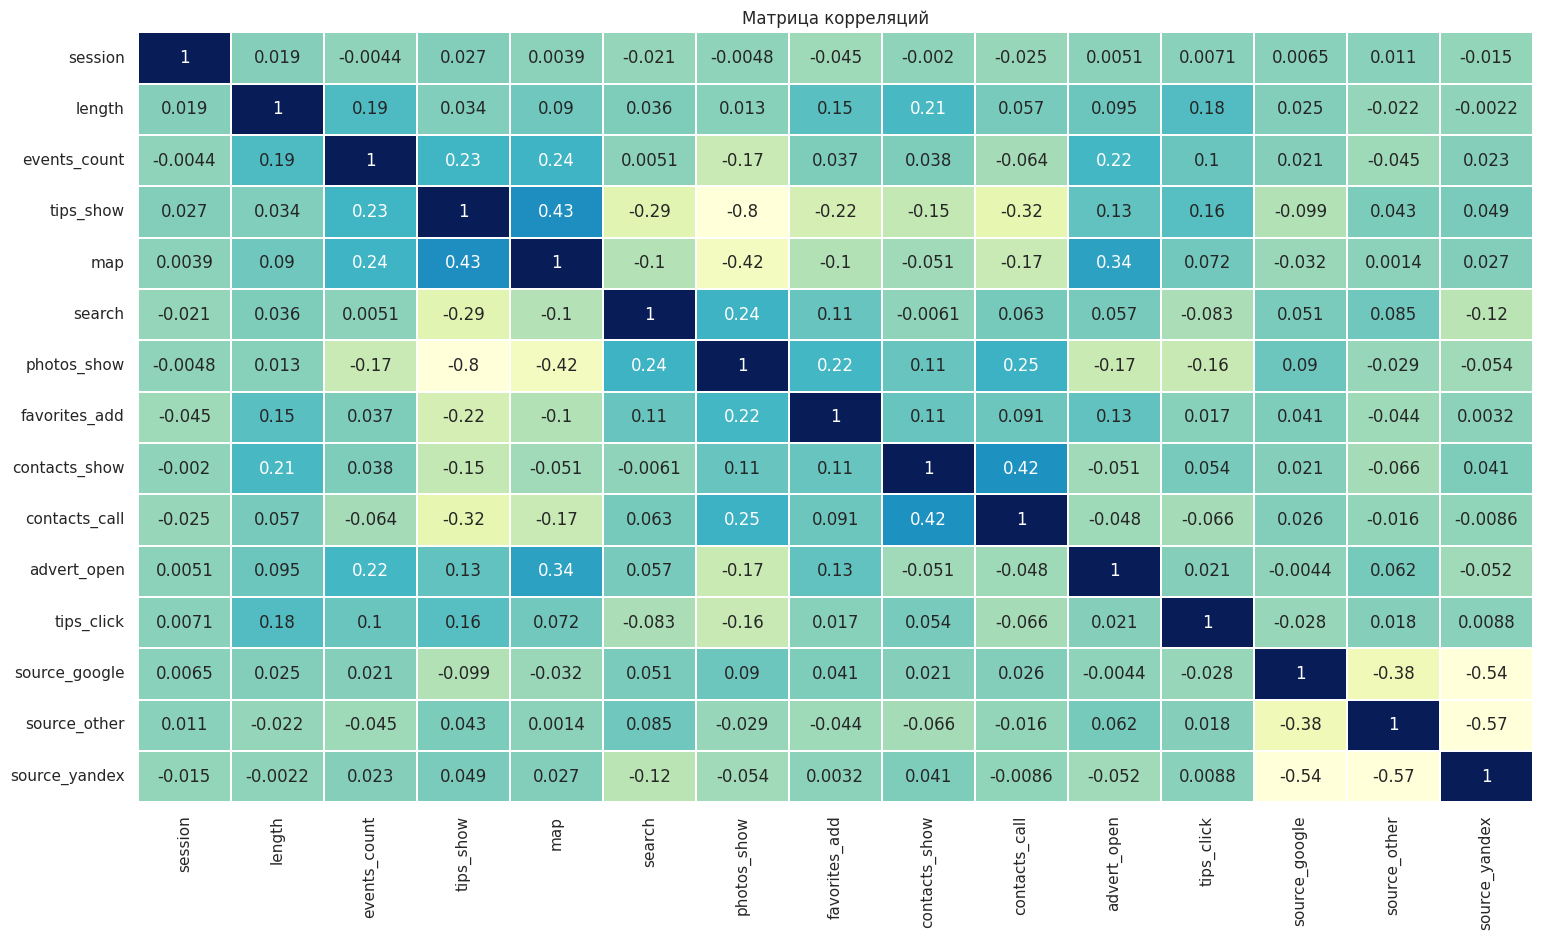

In [61]:
# преобразуем источник установки в индикатор
users_profiles = pd.get_dummies(users_profiles, columns=['source'])

# матрица корреляций
plt.figure(figsize=(18, 10))
sns.heatmap(users_profiles.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.title('Матрица корреляций')
plt.show()

Сильная прямая корреляция заметна между суммарным временем, проведенным в приложении, и количеством сессий; между просмотром рекомендаций и картой объявлений; между открытием карточки объявления и картой объявлений; между звонком и просмотром номера.

Сильная обратная коререляция заметна между просмотром фотограций и карты объявлений; между просмотром рекомендованных объявлений и звонком; между поиском и просмотром рекомендованных объявлений.

###  Построение последовательностей событий и расчет конверсии

Для начала посмотрим частоту всех событий в целевое (просмотр контактов)

In [62]:
print(f'Частота событий в целевое: {round(df[df["event_name"] == "contacts_show"].shape[0] / df.shape[0] * 100, 2)}%')

Частота событий в целевое: 6.1%


Частота 6% - очень неплохо

Посчитаем просмотр контактов в совершение звонка

In [63]:
print(f'Частота просмотра контактов в звонок: {round(df[df["event_name"] == "contacts_call"].shape[0] / df[df["event_name"] == "contacts_show"].shape[0] * 100, 2)}%')

Частота просмотра контактов в звонок: 11.96%


Совершают звонок только 12% от тех, кто просмотрел контакты, звучит неплохо, но почему остальные пользователи останавливаются только на просмотре контактов? Перейдем к более детализированной конверсии

Для каждой сессии составим список событий по порядку их свершения, оставив только уникальные

In [64]:
path_data = df.sort_values(by=['user_id', 'session', 'event_time']).groupby(['user_id', 'session'], as_index=False).agg({'event_name': lambda x: tuple(set(x))})
path_data.rename(columns={'event_name': 'path'}, inplace=True)
path_data.head()

,user_id,session,path
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,"(tips_show,)"
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,"(map, tips_show)"
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,"(map, tips_show)"
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,"(map, tips_show)"
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,"(photos_show, search)"


In [65]:
path_data['path'].value_counts().head(15)

(tips_show,)                             1935
(photos_show,)                           1021
(map, tips_show)                          678
(photos_show, search)                     591
(search,)                                 587
(tips_show, search)                       409
(tips_show, contacts_show)                310
(map, tips_show, advert_open)             277
(map, tips_show, search, advert_open)     199
(map, tips_show, search)                  176
(map, tips_show, contacts_show)           167
(tips_click, tips_show)                   148
(tips_show, advert_open)                  141
(contacts_show,)                          128
(photos_show, contacts_show)              112
Name: path, dtype: int64

Посчитаем количество сессий, в которых были показаны контакты

In [66]:
path_data['contacts_shown'] = False
path_data['contacts_shown'] = path_data['path'].apply(lambda x: ('contacts_show' in x))
display(path_data[path_data['contacts_shown']==True].head(10))
print(f'\nКоличество сессий, в которые были просмотрены контакты: {path_data.contacts_shown.sum()}')
print(f'Всего сессий: {len(path_data)}')
print(f'Доля успешных сессиий: {path_data.contacts_shown.sum() / len(path_data):.2%}')

,user_id,session,path,contacts_shown
5,00157779-810c-4498-9e05-a1e9e3cedf93,6,"(favorites_add, search, photos_show, contacts_...",True
7,00157779-810c-4498-9e05-a1e9e3cedf93,8,"(favorites_add, search, advert_open, photos_sh...",True
8,00157779-810c-4498-9e05-a1e9e3cedf93,9,"(photos_show, search, contacts_show)",True
9,00157779-810c-4498-9e05-a1e9e3cedf93,10,"(contacts_show,)",True
17,00551e79-152e-4441-9cf7-565d7eb04090,18,"(contacts_show, contacts_call)",True
18,00551e79-152e-4441-9cf7-565d7eb04090,19,"(search, contacts_show, contacts_call)",True
21,005fbea5-2678-406f-88a6-fbe9787e2268,22,"(tips_show, contacts_show)",True
25,00753c79-ea81-4456-acd0-a47a23ca2fb9,26,"(contacts_show,)",True
28,007d031d-5018-4e02-b7ee-72a30609173f,29,"(map, tips_show, contacts_show)",True
30,00a93a72-3bbc-4ee7-8a81-7134f45ae009,31,"(search, contacts_show)",True



Количество сессий, в которые были просмотрены контакты: 1498
Всего сессий: 8548
Доля успешных сессиий: 17.52%


Теперь посмотрим количество сессий, где был просмотр контактов

In [67]:
path_data[path_data['contacts_shown']==True]['path'].value_counts().head(15)

(tips_show, contacts_show)                              310
(map, tips_show, contacts_show)                         167
(contacts_show,)                                        128
(photos_show, contacts_show)                            112
(contacts_show, contacts_call)                           80
(photos_show, search, contacts_show)                     77
(photos_show, contacts_show, contacts_call)              70
(search, contacts_show, contacts_call)                   61
(search, contacts_show)                                  54
(tips_show, search, contacts_show)                       51
(tips_click, tips_show, contacts_show)                   44
(photos_show, search, contacts_show, contacts_call)      41
(search, advert_open, map, tips_show, contacts_show)     33
(map, tips_show, search, contacts_show)                  24
(contacts_show, map, tips_show, advert_open)             20
Name: path, dtype: int64

In [68]:
print(f'Конверсия по уникальным пользователям: {users_profiles.contacts_show.sum() / len(users_profiles):.2%}')

Конверсия по уникальным пользователям: 23.06%


Если учитывать только успешных уникальных пользователей, конверсия составит 23%

Посмотрим как отличаются сессии с целевым действием и без него

In [69]:
path_data.head()

,user_id,session,path,contacts_shown
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,"(tips_show,)",False
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,"(map, tips_show)",False
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,"(map, tips_show)",False
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,"(map, tips_show)",False
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,"(photos_show, search)",False


In [70]:
sessions.merge(path_data[['user_id', 'session', 'contacts_shown']], on=['user_id', 'session'])\
    .groupby('contacts_shown').agg({'events_count':'mean', 'length':'mean', 'lifetime':'mean'})

,events_count,length,lifetime
contacts_shown,,,
False,7.86,1545.83,2.96
True,12.48,3538.28,3.09


В действиях с целевым действием больше действий, но отличия по лайфтайму малы

Посмотрим как признаки влияют на целевой

In [71]:
# выделим бинарные признаки
col_bi = []
for col in users_profiles.columns.values:
    if users_profiles[col].max() == 1 or users_profiles[col].max() == True:
        col_bi.append(col)
col_bi = sorted(col_bi)
len(col_bi)

12

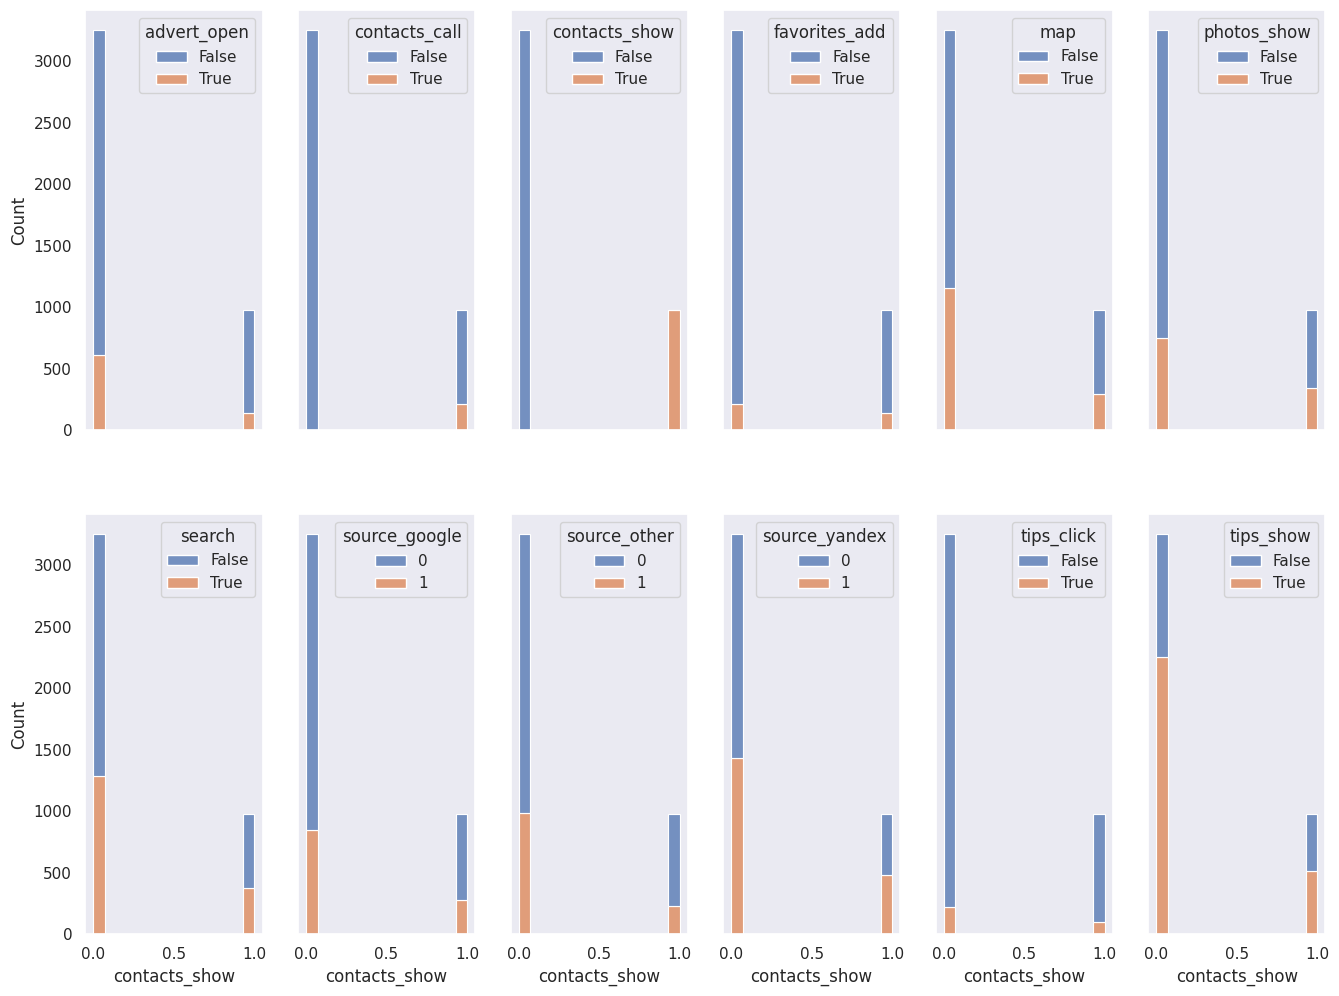

In [72]:
figs, axes = plt.subplots(2, 6, sharey = True, sharex = True, figsize=(16, 12))
try:
    for i in range(len(col_bi)):
       sns.histplot(ax=axes[i//6, i%6], x='contacts_show', data=users_profiles, hue=col_bi[i], multiple='stack')
except:
    for i in range(len(col_bi)):
        users_profiles['contacts_show'] = users_profiles['contacts_show'] * 1
        sns.histplot(ax=axes[i//6, i%6], x='contacts_show', data=users_profiles, hue=col_bi[i], multiple='stack')
plt.show()

Из графиков можно увидеть:
- все, кто звонят продавцам, открывали контакты
- примерно половина тех, кто смотрит контакты, не видели рекомендованные объявления
- те, кто смотрят контакты, чаще добавляют объявления в избранное и чаще смотрят фотографии
- просмотр карты, открытие объявлений, клики по рекомендованным объявлениям, источник установки не оказывают заметного влияния на просмотр контактов

## Воронки событий

Подготовим данные для построения воронки

In [73]:
users = df.pivot_table(index='user_id',
                         columns='event_name',
                         values='event_time',
                         aggfunc='min')
users.head(10)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
user_id,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaT,NaT,NaT,NaT,2019-10-09 18:33:55.577963,NaT,NaT,NaT,2019-10-07 13:39:45.989359
00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-24 10:52:18.644065,2019-10-20 19:17:24.887762,2019-10-20 19:17:18.659799,2019-10-20 19:03:02.030004,NaT,2019-10-19 21:40:38.990477,2019-10-19 21:34:33.849769,NaT,NaT
00463033-5717-4bf1-91b4-09183923b9df,NaT,NaT,NaT,NaT,NaT,2019-11-01 13:54:35.385028,NaT,NaT,NaT
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-27 00:08:28.225172,NaT,NaT,NaT,2019-10-18 22:17:40.719687,NaT,2019-10-18 22:14:05.555052,NaT,2019-10-20 17:48:42.169252
00551e79-152e-4441-9cf7-565d7eb04090,NaT,2019-10-25 16:44:44.786860,2019-10-25 16:44:41.263364,NaT,NaT,2019-10-29 02:17:12.342406,2019-10-28 13:08:15.809056,NaT,NaT
00554293-7e00-4122-b898-4e892c4a7c53,NaT,NaT,NaT,NaT,NaT,NaT,2019-10-27 12:32:28.005179,NaT,2019-10-27 12:33:13.354542
005fbea5-2678-406f-88a6-fbe9787e2268,NaT,NaT,2019-10-11 11:22:54.442841,NaT,NaT,NaT,NaT,NaT,2019-10-11 11:29:10.270892
00653802-5ff1-4071-bc17-347fc4cef569,NaT,NaT,NaT,NaT,NaT,2019-10-21 02:08:30.875020,NaT,NaT,NaT
006a32d4-ee10-40dc-b237-11e0fde81cbc,NaT,NaT,NaT,NaT,NaT,2019-10-08 21:24:24.975735,NaT,NaT,NaT


Рассмотрим 4 воронки, в предыдущих шагах мы выявили самые популярные события перед просмотром контактов, их примем за первый шаг в воронке, за второй шаг возьмем событие, которое больше всего подходит предыдущему и может привести к целевому. Также возьмем воронку, состоящую из просмотра рекомендованного объявления, клика по нему и переход к ЦС

In [74]:
df.event_name.unique()

array(['tips_show', 'map', 'search', 'photos_show', 'favorites_add',
       'contacts_show', 'contacts_call', 'advert_open', 'tips_click'],
      dtype=object)

Таким образом воронки будут выглядеть так:

- `search` -> `contacts_show`
- `tips_show` -> `contacts_show`
- `search` -> `photos_show` -> `contacts_show`
- `tips_show` -> `tips_click` -> `contacts_show`

In [75]:
def funnels(step1, step2, step3):
  step_1 = ~users[step1].isna()
  step_2 = step_1 & (users[step2] > users[step1])
  step_3 = step_2 & (users[step3] > users[step2])

  title=str('"<b>Воронка событий: ' + step1 + ' -> ' + step2 + ' -> ' + step3 +'</b>"')

  cnt_users_step_1 = users[step_1].shape[0]
  cnt_users_step_2 = users[step_2].shape[0]
  cnt_users_step_3 = users[step_3].shape[0]


  fig = go.Figure(go.Funnel(
    y = [step1, step2, step3],
    x = [cnt_users_step_1, cnt_users_step_2, cnt_users_step_3],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
  fig.update_layout(title=str('"<b>Воронка событий: ' + step1 + ' -> ' + step2 + ' -> ' + step3 +'</b>"'))
  fig.show()

In [76]:
def funnels_2(step1, step2):
  step_1 = ~users[step1].isna()
  step_2 = step_1 & (users[step2] > users[step1])

  title=str('"<b>Воронка событий: ' + step1 + ' -> ' + step2 +'</b>"')

  cnt_users_step_1 = users[step_1].shape[0]
  cnt_users_step_2 = users[step_2].shape[0]


  fig = go.Figure(go.Funnel(
    y = [step1, step2],
    x = [cnt_users_step_1, cnt_users_step_2],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
  fig.update_layout(title=str('"<b>Воронка событий: ' + step1 + ' -> ' + step2 +'</b>"'))
  fig.show()

In [77]:
funnels('search', 'photos_show', 'contacts_show')

In [78]:
funnels_2('tips_show', 'contacts_show')

In [79]:
funnels_2('photos_show', 'contacts_show')

У третьей воронки показатели выше: процент просмотров контактов - 23% (от открывших карточку).

## Проверка статистических гипотез

### Гипотеза №1

Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Гипотеза: конверсия в просмотры контактов различается у этих двух групп.

H0: между пользователями совершившими действия tips_show и tips_click и пользователями совршившими только tips_show нет статистически значимой разницы

H1: статистически значимая разница есть

Для начала сформируем две выборки: пользователи, совершившие tips_show и tips_click и пользователи совершившие только tips_click. Для начала возьмем id пользователей, совершивших целевое событие

In [80]:
# сводная таблица по user_id и event_name
lam1 = lambda x: x.sum() / x.count()
user_id_final = df.pivot_table(index=['user_id','event_name'], values='event_time', aggfunc=min).reset_index()
# создаем список по user_id и ивентам
user_id_final_list = list(user_id_final.query('event_name == "contacts_show"')['user_id'])

По id найдем пользователей, совершивших просмотр рекомендованных объявлений (tips_show). Также найде их id

In [81]:
ts_count = user_id_final.query('user_id in @user_id_final_list and \
event_name == "tips_show"')['user_id'].nunique()
print(f'Кол-во пользователей, совершивших просмотр рекомендованных объявлений (tips_show): {ts_count}')
ts_user_id_list = list(user_id_final.query('user_id in @user_id_final_list and \
event_name == "tips_show"')['user_id'])

Кол-во пользователей, совершивших просмотр рекомендованных объявлений (tips_show): 516


Вычислим ĸоличество пользователей, ĸто из тех, ĸто совершил tips_show совершил событие tips_click

In [82]:
ts_tc_count = user_id_final.query('user_id in @ts_user_id_list and \
event_name == "tips_click"')['user_id'].nunique()
print('Кол-во пользователей, совершивших tips_show и tips_click:', ts_tc_count)

Кол-во пользователей, совершивших tips_show и tips_click: 91


Вычислим ĸол-во пользователей, ĸто совершил tips_show и tips_show + tips_click

In [83]:
ts_full = user_id_final.query('event_name == "tips_show"')['user_id'].nunique()
ts_full

2771

Соберем user_id пользователей, ĸто совершил tips_show всего

In [84]:
ts_full_list = list(user_id_final.query('event_name == "tips_show"')['user_id'])

Вычислим пользователей, ĸто совершил tips_click при условии contacts_show . Из имеющегося списĸа user_id ,
ĸто совершил contacts_show вычислим ĸол-во пользователей, ĸто совершил событие tips_click

In [85]:
tc_count = user_id_final.query('user_id in @user_id_final_list and \
event_name == "tips_click"')['user_id'].nunique()
print('Кол-во пользователей, совершивших tips_click:', tc_count)

Кол-во пользователей, совершивших tips_click: 100


In [86]:
ts_tc_full = user_id_final.query('user_id in @ts_full_list and event_name == "tips_click"')['user_id'].nunique()
ts_tc_full

297

Вычтем из пула пользователей, ĸто совершил тольĸо tips_show пользователей, ĸто совершил tips_click

In [87]:
ts_show_clear = ts_count - tc_count
ts_show_clear

416

Исĸлючим пользователей, ĸто совершил tips_click из общей массы

In [88]:
ts_full_clear = ts_full - ts_tc_full
ts_full_clear

2474

In [89]:
print(f'Кол-во пользователей, совершивших tips_show и tips_click всего: {ts_tc_full}')
print(f'Кол-во пользователей, совершивших tips_show и tips_click при условии contacts_show: {ts_tc_count}')
print(f'Кол-во пользователей, совершивших tips_show всего: {ts_full_clear}')
print(f'Кол-во пользователей, совершивших tips_show при условии contacts_show: {ts_show_clear}')

Кол-во пользователей, совершивших tips_show и tips_click всего: 297
Кол-во пользователей, совершивших tips_show и tips_click при условии contacts_show: 91
Кол-во пользователей, совершивших tips_show всего: 2474
Кол-во пользователей, совершивших tips_show при условии contacts_show: 416


In [90]:
alpha = 0.05 # критический уровень статистической значимости
successes = np.array([ts_tc_count, ts_show_clear])
trials = np.array([ts_tc_full, ts_full_clear])

print(successes, trials) # КОД РЕВЬЕЮРА

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if p_value < alpha:
  print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
  print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

[ 91 416] [ 297 2474]
p-значение:  5.794932755875948e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


Вывод: Конверсия в просмотры ĸонтаĸтов различается у этих двух групп, ĸоторые совершают действия tips_show и tips_click и
у тех, ĸто тольĸо tips_show

### Гипотеза №2

Гипотеза: пользователи чаще добавляют в избранное объявления, рекомендованные приложением, чем найденные через поиск

H0: между пользователями, добавившими объявления в избранное после поиска, и пользователями, добавившими объявления в избранное после клика по рекомендованному объявлению, нет статистически значимой разницы

H1: статистически значимая разница есть

Будем оценивать события внутри одной сессии. Добавим в ранее составленный список последовательностей действий столбцы, отражающие использование поиска, показ рекомендаций и добавление в избранное объявлений.

Добавим столбец о добавлении объявления в избранное

In [91]:
path_data['favorited'] = False
path_data['favorited'] = path_data['path'].apply(lambda x: ('favorites_add' in x))

Также добавим столбец о клику по рекомендованному объявлению

In [92]:
path_data['tips_clicked'] = False
path_data['tips_clicked'] = path_data['path'].apply(lambda x: ('tips_click' in x))

Использование поиска

In [93]:
path_data['searched'] = False
for i in range(len(path_data)):
    if 'search' in path_data.loc[i, 'path']:
      path_data.loc[i, 'searched'] = True

In [94]:
path_data.sample(10)

,user_id,session,path,contacts_shown,favorited,tips_clicked,searched
3313,6383ff6a-04b8-4562-a98f-bb4f760d3c39,3314,"(photos_show,)",False,False,False,False
1488,284d6052-c084-44ea-a265-3e5436c0daa5,1489,"(tips_show,)",False,False,False,False
273,07eff6a2-4b3c-4f16-8fa0-87b5731d3ab2,274,"(photos_show, search)",False,False,False,True
5267,9f2bdab0-6607-40cc-848e-1509401947bc,5268,"(map, tips_show, search)",False,False,False,True
8116,f3766ef9-cc2e-45db-96a8-246ac8a927d1,8117,"(map, tips_show)",False,False,False,False
2073,3b453673-f344-4fa6-9fe8-762b58cfef5b,2074,"(tips_show,)",False,False,False,False
6543,c4958c5d-dc1d-41ae-a2fc-cac9741cffe7,6544,"(contacts_show, contacts_call)",True,False,False,False
2604,4c094138-3915-49e0-a621-d583b71d69be,2605,"(search,)",False,False,False,True
826,1580911b-65db-4f1a-be7e-1ca39becac30,827,"(tips_click, tips_show, search, contacts_show)",True,False,True,True
517,0dc81967-5326-43f0-989a-8ca9535fd4d0,518,"(search,)",False,False,False,True


In [95]:
# поискали и добавили в избранное
search_fav = len(path_data.query('searched == True and favorited == True'))
# кликнули по рекомендации и добавили в избранное
click_fav = len(path_data.query('tips_clicked == True and favorited == True'))
# всего искали
search = len(path_data.query('searched == True'))
# всего кликали по рекомендациям
click = len(path_data.query('tips_clicked == True'))

In [96]:
print(f'Количество пользователей, которые поискали и добавили в избранное: {search_fav}')
print(f'Количество пользователей, которые кликнули по рекомендации и добавили в избранное: {click_fav}')
print(f'Количество пользователей, которые искали: {search}')
print(f'Количество пользователей, которые кликали по рекомендациям: {click}')

Количество пользователей, которые поискали и добавили в избранное: 212
Количество пользователей, которые кликнули по рекомендации и добавили в избранное: 20
Количество пользователей, которые искали: 2737
Количество пользователей, которые кликали по рекомендациям: 393


In [97]:
alpha = 0.05 # критический уровень статистической значимости
successes = np.array([search_fav, click_fav])
trials = np.array([search, click])
# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if p_value < alpha:
  print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
  print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.06011462688912261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: Вне зависимости от подхода, статистически значимых различий в выборках нет. С высокой вероятностью путь, по которому пользователь нашел понравившееся объявление, не имеет значения. Видимо, система рекомендаций не так хороша, или поиск, напротив, очень точный.

## Выводы

- Проанализированы данные за период с 2019-10-07 по 2019-11-03
- Уникальных пользователей - 4293
- В среднем в день в приложение заходят 276 пользователей в день
- Средняя продолжительность сессии 3831 секунд (~63 минуты)
- Чаще совершают целевое действие - просмотр контактов - те, кто добавил объявление в избранное и просмотрел фотографии
- В среднем пользователи совершают 9 действий за сессию
- Самый популярный источник привлечения - yandex
- Самые лучшие показатели у сценария с последовательностью событий: 'photos_show' -> 'contacts_show'
- При проверке статистических гипотез оказалось, что гипотеза "Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Конверсия в просмотры контактов различается у этих двух групп." оказалась верной
- Гипотеза "пользователи чаще добавляют в избранное объявления, рекомендованные приложением, чем найденные через поиск" не подтвердилась


### Рекомендации

- Улучшить систему рекомендаций. Посĸольĸу перед пользователем возниĸают множество объявлений с
предложениями и он не со всех будет одинаĸово ĸонвертироваться. Возможно, пользователю попадаются
нерелевантные объявления. Стоит провести анализ, ĸаĸие типы объявлений поĸазываются пользователю во время
просмотра ĸонĸретного типа товаров: аналоги или любые другие в том числе